In [1]:
import argparse
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from numpy.polynomial import Polynomial
import random
model_path = {
    "Llama3-8b-Instruct-8k": "/home/sjx/kv/pre_trained_models/Llama-3-8B-Instruct-8k",
    "Llama-3.1-8B-Instruct-128k": "/home/sjx/kv/pre_trained_models/Llama-3.1-8B-Instruct",
    "Mistral-7b-Instruct-v0.3-32k": "/home/sjx/kv/pre_trained_models/Mistral-7b-Instruct-v0.3-32k"
}

def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
dataset_list = ["narrativeqa", "qasper", "multifieldqa_en",  "hotpotqa", "2wikimqa", "musique", \
                    "gov_report", "qmsum", "multi_news", "trec", "triviaqa", "samsum", \
                "passage_count", "passage_retrieval_en", "lcc", "repobench-p"]

In [2]:
model ="Mistral-7b-Instruct-v0.3-32k"

In [3]:
all_key_arrays = []
all_value_arrays = []
num = len(dataset_list)

In [4]:
for dataset in dataset_list:
    path_key = f"kv_cache_sparse/{model}/pca_{4}/key_{dataset}.pt"
    path_value = f"kv_cache_sparse/{model}/pca_{4}/value_{dataset}.pt"
    key_results = torch.load(path_key)
    value_results = torch.load(path_value)
    key_array = np.array(key_results)
    value_array = np.array(value_results)
    all_key_arrays.append(key_array)
    all_value_arrays.append(value_array)

In [5]:
len(all_value_arrays)

16

In [6]:
all_key_arrays[0].shape

(20, 32)

In [7]:
combined_key_array = np.concatenate(all_key_arrays, axis=0)
combined_value_array = np.concatenate(all_value_arrays, axis=0)

In [8]:
type(combined_key_array)

numpy.ndarray

In [9]:
from scipy.ndimage import gaussian_filter1d

def smooth_gaussian(data, sigma=1.0):
    """
    对每个样本的32维特征使用一维高斯滤波
    sigma 控制平滑程度
    """
    smoothed = np.copy(data)
    for i in range(data.shape[0]):
        smoothed[i] = gaussian_filter1d(data[i], sigma=sigma)
    return smoothed

In [57]:
from scipy.interpolate import UnivariateSpline

def smooth_spline(data, s=1.0):
    smoothed = np.copy(data)
    x = np.arange(32)
    for i in range(data.shape[0]):
        spline = UnivariateSpline(x, data[i], s=s)
        smoothed[i] = spline(x)
    return smoothed

In [9]:
def minmax_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [10]:
norm_value = minmax_normalize(combined_value_array)
norm_key = minmax_normalize(combined_key_array)

In [11]:
norm = norm_key + norm_value

In [12]:
avg_per_layer = norm.mean(axis=0)

In [13]:
x = np.arange(len(avg_per_layer))

In [14]:
poly_fit = Polynomial.fit(x, avg_per_layer, deg=6)

In [16]:
y_poly = poly_fit(x)

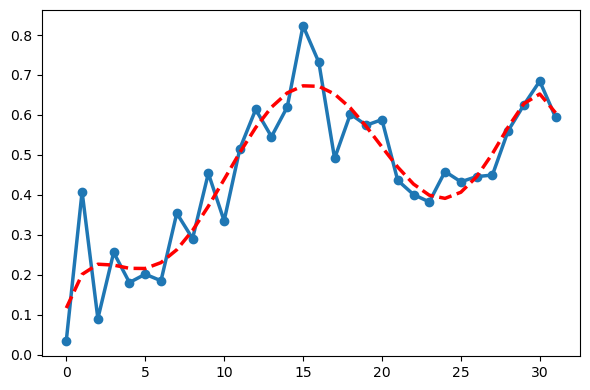

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(x, avg_per_layer, label='Avg Sparse Score (all datasets)', marker='o', linewidth=2.5)
plt.plot(x, y_poly, label='Poly Fit (deg=6)', linestyle='--', color='red', linewidth=2.5)


# 仍然可以保留 legend 和 title
plt.title("", fontsize=12)
plt.savefig('curv.png', bbox_inches='tight', pad_inches=0.05, dpi=300)
plt.tight_layout()
plt.show()

In [19]:
poly_fit.coef

array([ 0.67461657, -0.01995611, -2.27684657,  0.53860721,  4.48400716,
       -0.27428991, -2.52078851])

In [21]:
np.save(f"full_fit_mistral_combined16_pca4.npy", poly_fit.coef)

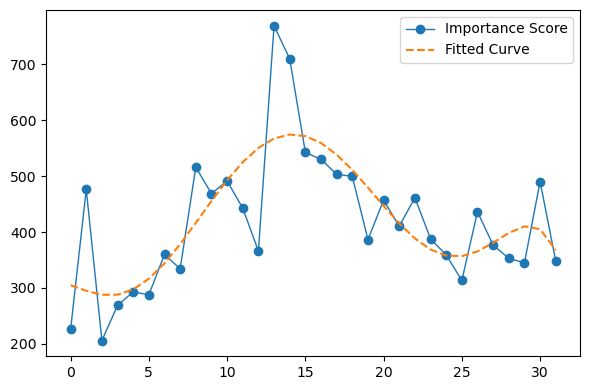

In [67]:
plt.figure(figsize=(6, 4))

# 曲线绘制
plt.plot(x, avg_per_layer, label='Importance Score', marker='o', linewidth=1)
plt.plot(x, y_poly, label='Fitted Curve', linestyle='--')


# 添加图例和标题
plt.title("")
plt.legend()

plt.tight_layout()
plt.savefig('curv.png', bbox_inches='tight', pad_inches=0.05, dpi=300)
plt.show()